# ✍ **Example of usage Spark OCR with Dicom Image Deidentifier**

Spark OCR is a library that combines optical character recognition (OCR) capabilities with Apache Spark, enabling scalable and distributed processing of OCR tasks. It is designed to handle various types of documents, including medical images in the DICOM format. One specific functionality provided by Spark OCR is DICOM image deidentification.

DICOM (Digital Imaging and Communications in Medicine) is a widely used standard for storing and transmitting medical images, such as X-rays, CT scans, and MRI scans. These images often contain sensitive patient information, including personal identifiers, that need to be protected to comply with privacy regulations.

The DICOM image deidentifier in Spark OCR is a feature that allows for the anonymization or removal of patient-specific information from DICOM images. This process helps to ensure patient privacy and confidentiality when sharing or storing medical images.

When using Spark OCR's DICOM image deidentifier, the library applies techniques to detect and redact or remove sensitive information from the DICOM image headers and pixel data. It can handle various types of DICOM metadata, such as patient name, identification numbers, dates of birth, and other identifying information.

The deidentification process in Spark OCR can be performed at scale using Apache Spark's distributed computing capabilities. This means that large collections of DICOM images can be processed efficiently and in parallel across a cluster of machines, enabling fast and scalable deidentification workflows.

By utilizing Spark OCR's DICOM image deidentifier, healthcare organizations, researchers, and other stakeholders can ensure compliance with privacy regulations while still being able to leverage the benefits of OCR for medical image analysis, research, and other applications.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/3.1.SparkOcr_Image_DeIdentification.ipynb)

#🎬 Installation

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

# 🔑 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')

license_keys = files.upload()

# 🔑  Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

#📌 Starting

In [ ]:
from johnsnowlabs import nlp, visual, medical
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.1, 💊Spark-Healthcare==4.4.3, 🕶Spark-OCR==4.4.2, running on ⚡ PySpark==3.1.2


In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

In [ ]:
!gdown 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

Downloading...
From: https://drive.google.com/uc?id=1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS
To: /content/cTDaR_t10096.jpg
100% 385k/385k [00:00<00:00, 38.3MB/s]


## 🧮 Import Spark OCR transformers and Spark NLP annotators



In [ ]:
import matplotlib.pyplot as plt

## Define de-identification  NLP pipeline

A de-identification NLP (Natural Language Processing) pipeline refers to a series of steps and techniques used to remove or anonymize sensitive or personally identifiable information (PII) from text data. The primary goal of a de-identification NLP pipeline is to protect privacy and confidentiality while still allowing the data to be used for analysis, research, or other purposes.

In [ ]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = nlp.SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = medical.NerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = nlp.NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [ ]:
from pyspark.ml import Pipeline
# Convert to images
binary_to_image = visual.BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw")

# Extract text from image
ocr = visual.ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(visual.PageIteratorLevel.SYMBOL) \
    .setPageSegMode(visual.PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = visual.ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(visual.Color.gray)


# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

## ⏳ Load image

In [ ]:
image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')
image_df = spark.read.format("binaryFile").load(image_path)

## 🏃 Run pipeline

In [ ]:
result = pipeline.fit(image_df).transform(image_df).cache()

## Display chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('ner_chunk').show(2, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{chunk, 196, 205, 04/04/2018, {entity -> DATE, sentence -> 0, chunk -> 0, confidence -> 0.9999}, []}, {chunk, 3387, 3396, 04/12/2018, {entity -> DATE, sentence -> 18, chunk -> 1, confidence -> 1.0}, []}]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Display coordinates of chunks which need to hide

In [ ]:
# NBVAL_SKIP
result.select('coordinates').show(2, False)

+------------------------------------------------------------------------------------------------------------+
|coordinates                                                                                                 |
+------------------------------------------------------------------------------------------------------------+
|[{0, 0, 357.0, 1053.3, 213.20001, 37.4, 0.0, 0, 0.0}, {1, 0, 496.0, 3527.98, 239.79999, 40.04, 0.0, 0, 0.0}]|
+------------------------------------------------------------------------------------------------------------+



## Show original and de-identified images

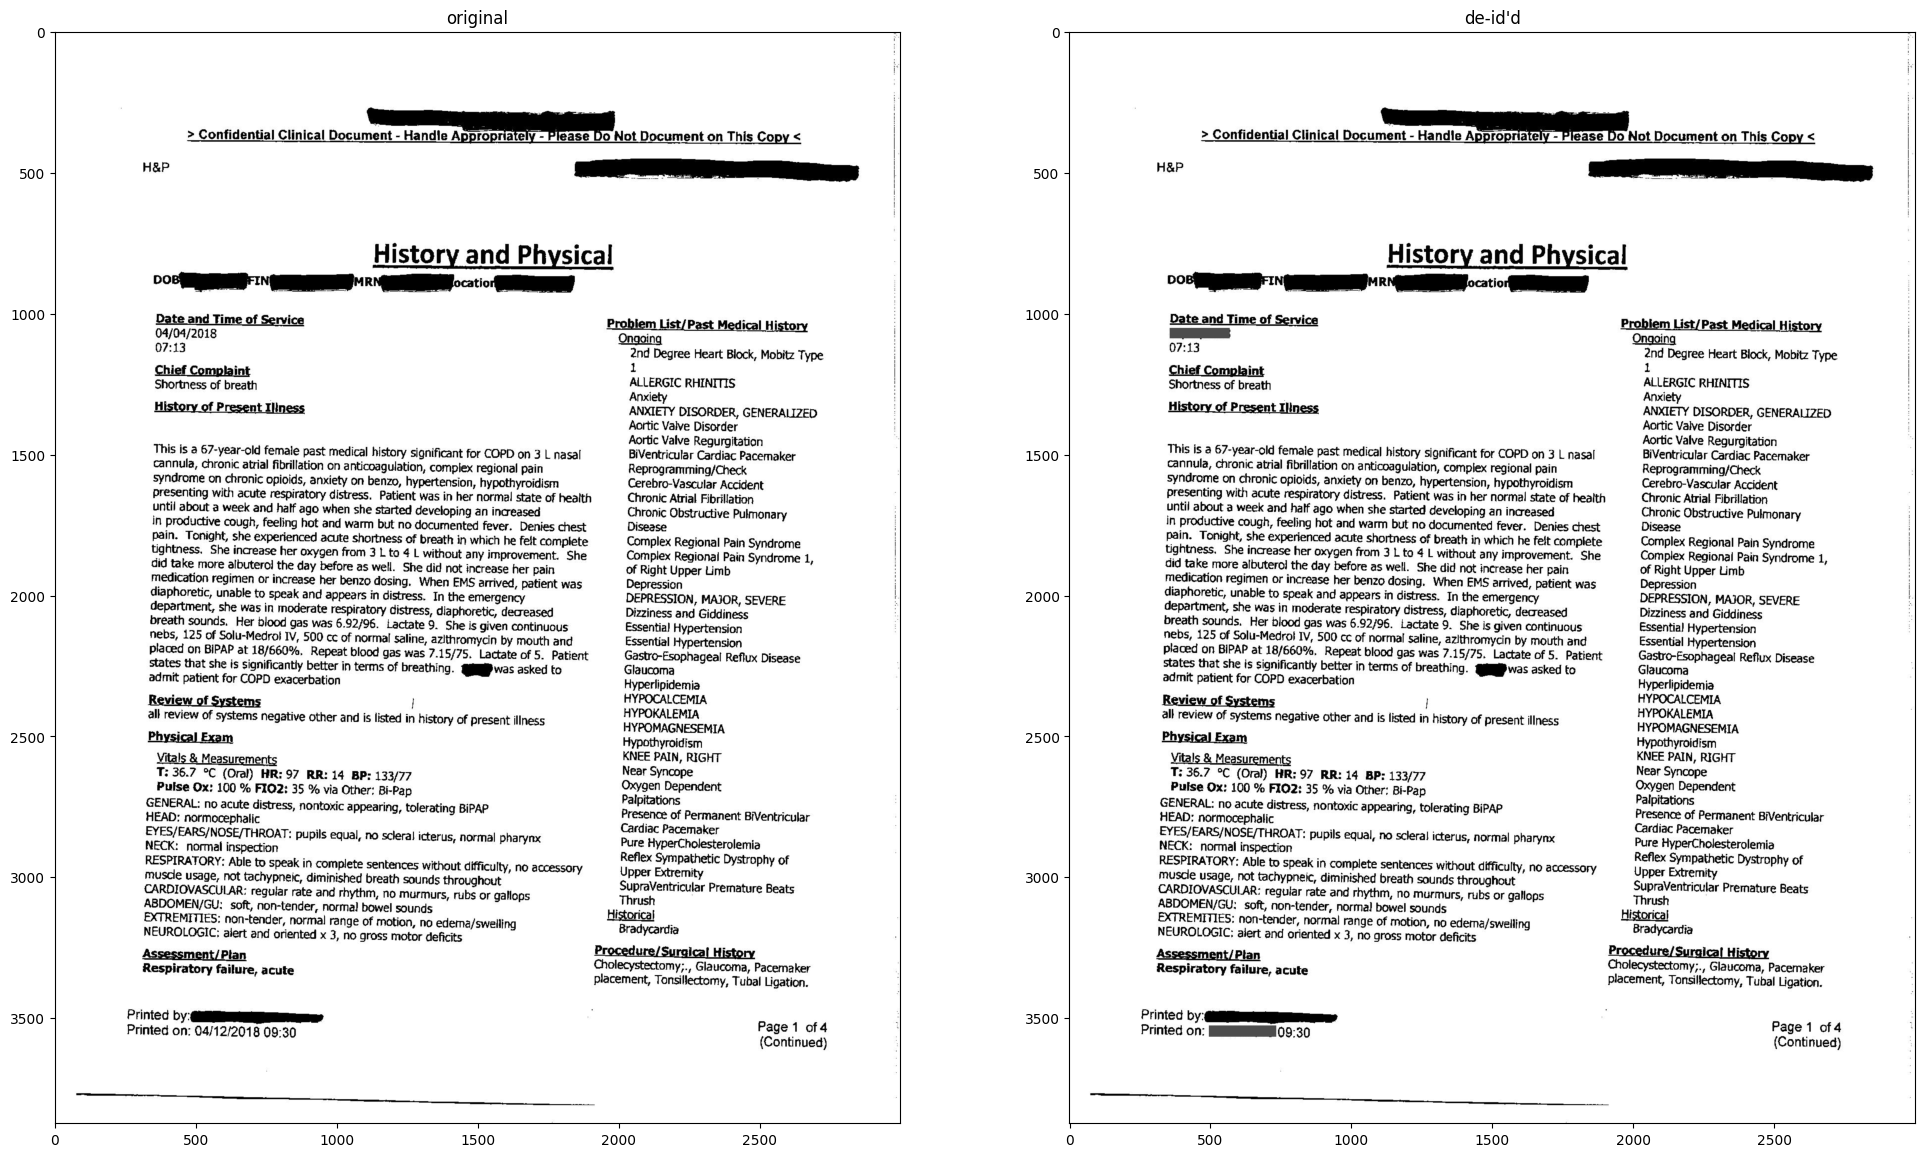

In [ ]:
# NBVAL_SKIP
for r in result.select("image_raw", "image_with_regions").collect():
    img_orig = r.image_raw
    img_deid = r.image_with_regions

    img_pil_orig = visual.to_pil_image(img_orig, img_orig.mode)
    img_pil_deid = visual.to_pil_image(img_deid, img_deid.mode)

    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil_orig, cmap='gray')
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil_deid, cmap='gray')
    plt.title("de-id'd")
    plt.show()

## Store result

In [ ]:
# NBVAL_SKIP
import os
output_path = "././data/images/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in result.select("image_with_regions", "path").collect():
    path, name = os.path.split(r.path)
    file_name = os.path.join(output_path, name)
    print(f"Storing to {file_name}")

    im = visual.to_pil_image(r.image_with_regions, r.image_with_regions.mode)
    im.save(file_name)

Storing to ././data/images/deidentified/p1.jpg


## Remove results

In [ ]:
%%bash
rm -r -f ././data/images/deidentified